# Anomaly Detection

This notebook shows some basic usage of CapyMOA for anomaly detection tasks.

Algorithms: `HalfSpaceTrees`, `Autoencoder` and `Online Isolation Forest`

Important notes: Prior to version 0.8.2, a lower anomaly score indicated a higher likelihood of an anomaly. This has been updated so that a higher anomaly score now indicates a higher likelihood of an anomaly, aligning with the standard anomaly detection literature.

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 28/11/2025**

## 1. Creating simple anomalous data with `sklearn`

* Generating a few examples and some simple anomalous data using `sklearn`.

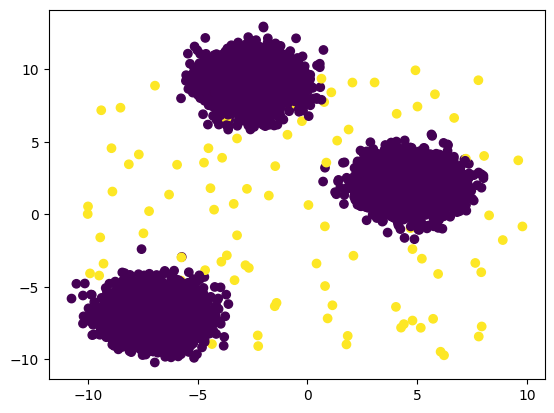

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 10000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 100  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

## 2. Unsupervised anomaly detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions, we first use a basic **test-then-train loop** from scratch to evaluate the model's performance.
* Please note that higher scores indicate higher anomaly likelihood.

In [2]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
learner = HalfSpaceTrees(stream_ad.get_schema())
evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())
while stream_ad.has_more_instances():
    instance = stream_ad.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)

auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.95


## 3. High-level evaluation functions

* CapyMOA provides `prequential_evaluation_anomaly` as a high level function to assess anomaly detectors.

### 3.1 `prequential_evaluation_anomaly`
In this example, we use the `prequential_evaluation_anomaly` function with `plot_windowed_results` to plot AUC for HalfSpaceTrees on the synthetic data stream.

AUC: 0.948493


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.874663,0.182711,0.064,0.001332,0.000000,0.012146,0.229416,1.0,-77.000000
1,2000.0,0.961608,0.210984,0.005,0.000000,0.874663,0.005025,0.000000,1.0,-116.058824
2,3000.0,0.968539,0.218827,0.012,0.000000,0.961608,0.012146,0.000000,1.0,-101.206897
3,4000.0,0.951515,0.217991,0.010,0.000000,0.968539,0.010101,0.000000,1.0,-100.538462
4,5000.0,0.964196,0.188622,0.015,0.000000,0.951515,0.015228,0.000000,1.0,-90.203704
5,6000.0,0.992161,0.212583,0.005,0.000000,0.964196,0.005025,0.000000,1.0,-100.186441
6,7000.0,0.958268,0.205480,0.011,0.000000,0.992161,0.011122,0.000000,1.0,-97.900000
7,8000.0,0.953488,0.210055,0.011,0.000000,0.958268,0.011122,0.000000,1.0,-96.679012
8,9000.0,0.933216,0.168399,0.008,0.000000,0.953488,0.008065,0.000000,1.0,-99.314607
9,10000.0,0.981708,0.214861,0.011,0.000000,0.933216,0.011122,0.000000,1.0,-97.900000


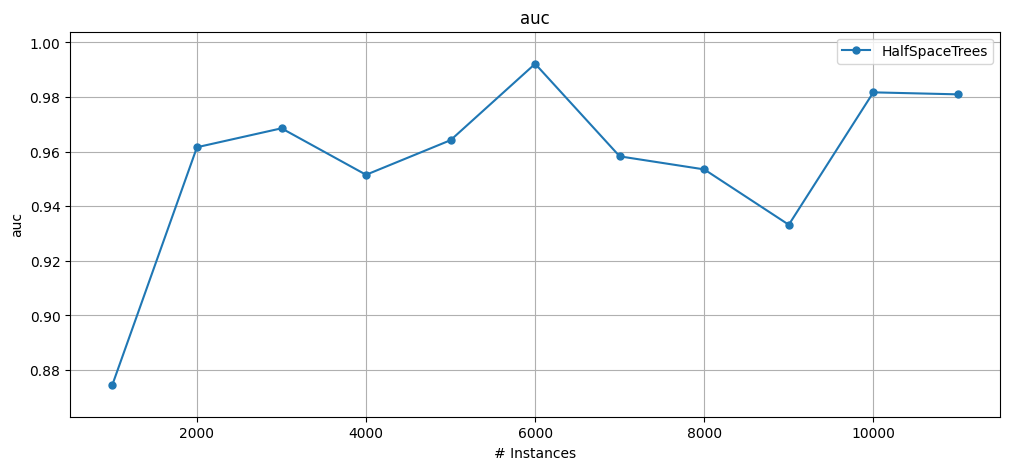

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
hst = HalfSpaceTrees(schema=stream_ad.get_schema())

results_hst = prequential_evaluation_anomaly(
    stream=stream_ad, learner=hst, window_size=1000
)

print(f"AUC: {results_hst.auc()}")
display(results_hst.windowed.metrics_per_window())
plot_windowed_results(results_hst, metric="auc", save_only=False)

### 3.2 Autoencoder

AUC: 0.562556


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.608384,1.089317e-04,0.987,-0.001850,0.000000,0.012146,0.000000,0.0,-0.083333
1,2000.0,0.649447,5.898215e-06,0.994,-0.001669,0.608384,0.005025,0.000000,0.0,0.294118
2,3000.0,0.588310,5.939977e-03,0.987,-0.001850,0.649447,0.012146,0.000000,0.0,-0.344828
3,4000.0,0.534747,5.589712e-02,0.991,0.180328,0.588310,0.010101,0.316228,0.1,0.076923
4,5000.0,0.458883,8.677773e-04,0.985,0.000000,0.534747,0.015228,0.000000,0.0,-0.388889
5,6000.0,0.465729,9.141556e-07,0.994,-0.001669,0.458883,0.005025,0.000000,0.0,0.389831
6,7000.0,0.627815,4.753149e-02,0.989,0.000000,0.465729,0.011122,0.000000,0.0,-0.100000
7,8000.0,0.651163,2.229827e-05,0.988,-0.001837,0.627815,0.011122,0.000000,0.0,-0.185185
8,9000.0,0.504662,3.494982e-03,0.992,0.000000,0.651163,0.008065,0.000000,0.0,0.191011
9,10000.0,0.546190,6.503471e-07,0.989,0.000000,0.504662,0.011122,0.000000,0.0,-0.100000


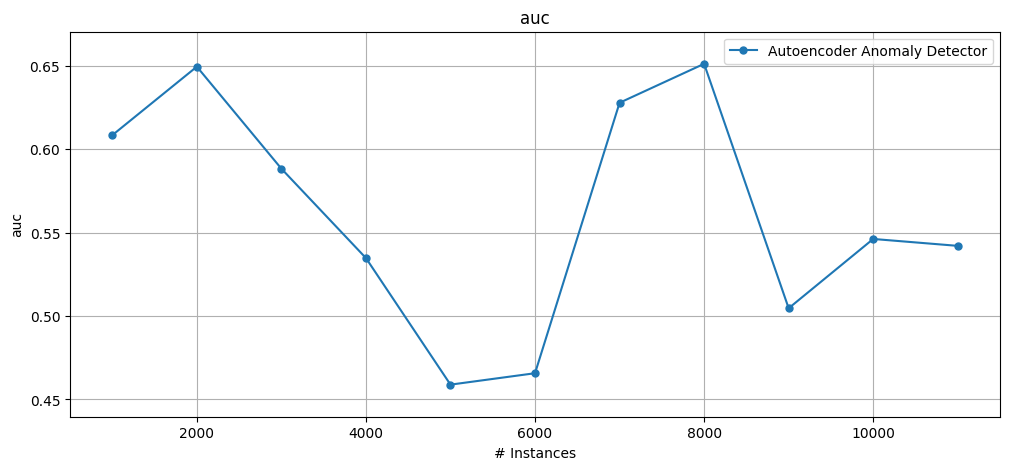

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")
display(results_ae.windowed.metrics_per_window())
plot_windowed_results(results_ae, metric="auc", save_only=False)

### 3.3 Online Isolation Forest

AUC: 0.827975


,instances,auc,s_auc,Accuracy,Kappa,Periodical holdout AUC,Pos/Neg ratio,G-Mean,Recall,KappaM
0,1000.0,0.699393,0.037054,0.955,-0.017915,0.000000,0.012146,0.0,0.0,-2.750000
1,2000.0,0.840603,0.061799,0.995,0.000000,0.699393,0.005025,0.0,0.0,0.411765
2,3000.0,0.829791,0.065623,0.988,0.000000,0.840603,0.012146,0.0,0.0,-0.241379
3,4000.0,0.832727,0.052678,0.990,0.000000,0.829791,0.010101,0.0,0.0,-0.025641
4,5000.0,0.921083,0.076654,0.985,0.000000,0.832727,0.015228,0.0,0.0,-0.388889
5,6000.0,0.996985,0.114542,0.995,0.000000,0.921083,0.005025,0.0,0.0,0.491525
6,7000.0,0.871955,0.045403,0.989,0.000000,0.996985,0.011122,0.0,0.0,-0.100000
7,8000.0,0.854582,0.053205,0.989,0.000000,0.871955,0.011122,0.0,0.0,-0.086420
8,9000.0,0.515121,0.018523,0.992,0.000000,0.854582,0.008065,0.0,0.0,0.191011
9,10000.0,0.983638,0.093084,0.989,0.000000,0.515121,0.011122,0.0,0.0,-0.100000


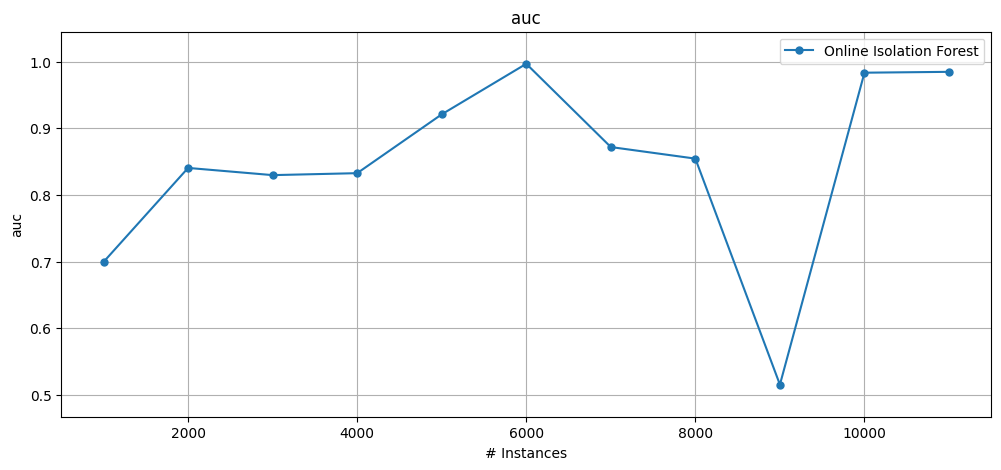

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import prequential_evaluation_anomaly

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)
oif = OnlineIsolationForest(schema=stream_ad.get_schema(), num_trees=10)

results_oif = prequential_evaluation_anomaly(
    stream=stream_ad, learner=oif, window_size=1000
)

print(f"AUC: {results_oif.auc()}")
display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## 4. Comparing algorithms

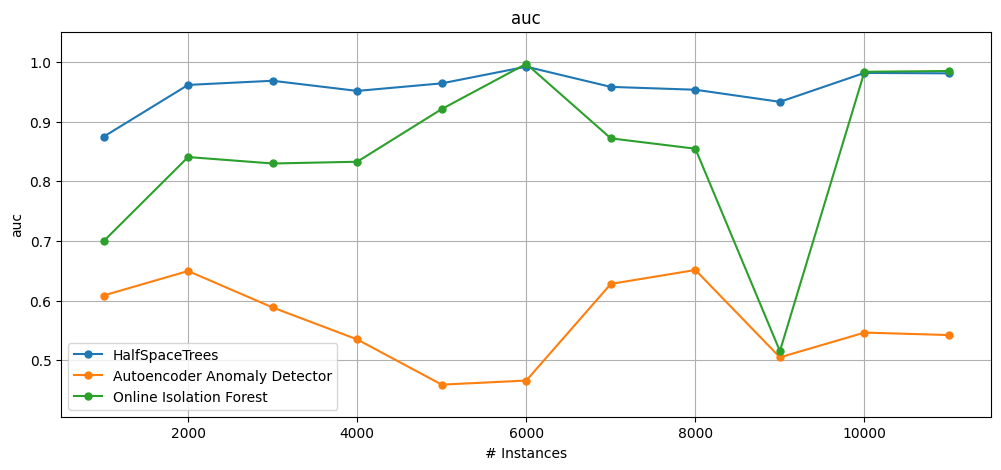

In [6]:
plot_windowed_results(
    results_hst, results_ae, results_oif, metric="auc", save_only=False
)